In [37]:
import math
import multiprocessing
import os
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.color
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.autonotebook import tqdm
from os.path import join

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import util
import visual_words
import visual_recog
from opts import get_opts

In [38]:
#Options class
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2),
        K=10,
        alpha=25,
        L=1,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [39]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


In [40]:
def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''

    filter_scales = opts.filter_scales
    # ----- TODO -----
    img_dimensions = img.shape
    if len(img_dimensions) == 2:
        img = np.matlib.repmat(img, 3, 1)
    if img_dimensions[2] > 3:
        img = img[:,:,0:3]
    
    image = skimage.color.rgb2lab(img)
    filter_responses = np.zeros((img_dimensions[0], img_dimensions[1], 12*len(filter_scales))) 
    #12 because 3 channels * 4 filter types  (then times each filter scale)
    for i, scale in enumerate(filter_scales):
        for channel in range(3):
            response_gaussian = scipy.ndimage.gaussian_filter(image[:, :, channel], scale)
            filter_responses[:,:,(12*i) + channel] = response_gaussian
            response_laplacian = scipy.ndimage.gaussian_laplace(image[:, :, channel], scale)
            filter_responses[:,:,(12*i)+3+channel] = response_laplacian
            response_x_deriv = scipy.ndimage.gaussian_filter(image[:, :, channel], scale, [0, 1])
            filter_responses[:,:,(12*i)+6+channel] = response_x_deriv
            response_y_deriv = scipy.ndimage.gaussian_filter(image[:,:,channel], scale, [1, 0])
            filter_responses[:,:,(12*i)+9+channel] = response_y_deriv
    return filter_responses

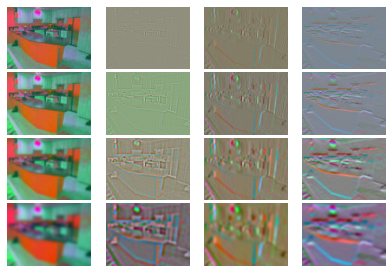

In [41]:
# Should have filters for at least 3 scales.

opts.filter_scales = [1, 2, 4, 8]
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

In [42]:
def compute_dictionary_one_image(args):
    opts, idx, img_path = args

    #image = skimage.io.imread(img_path)
    image = plt.imread(img_path)
    image = image.astype('float')/255
    filter_response = extract_filter_responses(opts, image)
    h, w, c = filter_responses.shape

    alpha = opts.alpha
    rand_pixel_h = np.random.permutation(h)[:alpha]
    rand_pixel_w = np.random.permutation(w)[:alpha]
    random_samples = np.zeros((alpha, c))
    for i in range(alpha):
        h_ind = rand_pixel_h[i]
        w_ind = rand_pixel_h[i]
        random_samples[i, :] = filter_responses[h_ind, w_ind, :]
    
    dir_path = './temporary'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    np.save(os.path.join(dir_path, str(idx)+'.npy'), random_samples)
    




In [43]:
def compute_dictionary(opts, n_worker = 1):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """
    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K
    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = open(join(data_dir, "train_labels.txt")).read().splitlines()
    train_paths = [os.path.join(data_dir, name[0]) for name in train_files]
    pool = multiprocessing.Pool(processes = n_worker*8)
    args = zip(opts, range(len(train_paths)), train_paths)
    pool.map(compute_dictionary_one_image, args)




    
    



In [46]:
compute_dictionary_one_image((opts, 1, join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')))

t = [1, 2, 3, 4, 6]
t = t[:2]
print(t)


[1, 2]


In [49]:
train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
print(len(train_files))

1177


In [51]:
test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)
print(test_labels.shape)


(400,)


In [54]:
a = np.array([])
b = np.array([1, 2, 3, 4])
a = np.append(a, b)
print(a)


[1. 2. 3. 4.]


In [55]:
data_dir = opts.data_dir
train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
print(train_files)
train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
print(train_labels)
train_paths = [join(data_dir, name) for name in train_files]
print(train_paths)


['aquarium/sun_asgtepdmsxsrqqvy.jpg', 'aquarium/sun_atkpnmclzeougwrr.jpg', 'aquarium/sun_aemkpicofpiyagbu.jpg', 'aquarium/sun_awijoserfvrfcabw.jpg', 'aquarium/sun_ackffcrfuhrobpeb.jpg', 'aquarium/sun_aojksxuidkkhitdv.jpg', 'aquarium/sun_aztvjgubyrgvirup.jpg', 'aquarium/sun_auhbzrixgbnkynar.jpg', 'aquarium/sun_aiulpgjqwnxqiooi.jpg', 'aquarium/sun_axftbpasnkrpiacj.jpg', 'aquarium/sun_auashajszqdlulfv.jpg', 'aquarium/sun_acxgqibvrceprjuw.jpg', 'aquarium/sun_akjpgxvhcvynabhn.jpg', 'aquarium/sun_astxqnwrxgglhrbt.jpg', 'aquarium/sun_ammsvbpxuzzhsomk.jpg', 'aquarium/sun_aqnfaunviqzzfywv.jpg', 'aquarium/sun_axgloeychjvfslqg.jpg', 'aquarium/sun_ahknjrjsekrjavqi.jpg', 'aquarium/sun_aamlnkpomzzujqpa.jpg', 'aquarium/sun_aguvvqkaqcoqtvta.jpg', 'aquarium/sun_amjxfdjjpymuevrb.jpg', 'aquarium/sun_amlvhxieawuiqjly.jpg', 'aquarium/sun_aeumnndigcrqshun.jpg', 'aquarium/sun_abjdxrerqnflewtw.jpg', 'aquarium/sun_aoktasrtzmmkjadm.jpg', 'aquarium/sun_ajnpxlprhqiqnilu.jpg', 'aquarium/sun_aymhwibsalbedtra.jpg', 

In [56]:
a = [1, 2, 3]
b = 4
print(np.array(np.append(a, b)))

[1 2 3 4]
